# Algorithmic Trading Strategy Challenge

Name: Hrishi Mehta 

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Strategy Implementation

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

class NeuralNetworkStrategy:
    def __init__(self, ticker, start_date, end_date):
        """
        Initialize the trading strategy with key parameters.
        
        Args:
            ticker (str): The stock ticker symbol.
            start_date (str): The start date for data collection.
            end_date (str): The end date for data collection.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model = MLPRegressor(
            #https://stackoverflow.com/questions/55786860/how-is-the-hidden-layer-size-determined-for-mlpregressor-in-scikitlearn 
            hidden_layer_sizes=(100, 100, 100),  # Number of neurons in each hidden layer
            max_iter=3000,  # Maximum number of iterations for the solver
            random_state=42,  # Seed for random number generation for reproducibility
            alpha=0.0001  # L2 regularization term (also known as weight decay)
        )
        self.scaler = StandardScaler()
        self.data = None
        self.balance = 200000  # Initial balance
        self.shares_held = 0
        self.signals = []  # Track trading signals
        self.positions = []  # Track positions
        self.trade_info = []  # Track trade information
        self.invested_capital = 0 

    def download_data(self):
        """
        Download historical stock price data for the specified ticker and date range.
        """
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        
    def calculate_rsi(self, prices, window):
        """
        Calculate the Relative Strength Index (RSI) for a given series of prices.
        
        Got calculation help from: https://stackoverflow.com/questions/57006437/calculate-rsi-indicator-from-pandas-dataframe 
        
        Args:
            prices (pd.Series): The price data for which RSI is calculated.
            window (int): The time period for RSI calculation.
        
        Returns:
            pd.Series: The RSI values.
        """
        difference = prices.diff(1)
        gain = difference.where(difference > 0, 0)
        loss = -difference.where(difference < 0, 0)
        average_gain = gain.rolling(window=window, min_periods=1).mean()
        average_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = average_gain / average_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_atr(self, high, low, closing, window):
        """
        Calculate the Average True Range (ATR) for a given series of high, low, and closing prices. 
        
        Got calculation help from: https://stackoverflow.com/questions/40256338/calculating-average-true-range-atr-on-ohlc-data-with-python 
        
        Args:
            high (pd.Series): The high price data.
            low (pd.Series): The low price data.
            closing (pd.Series): The closing price data.
            window (int): The time period for ATR calculation.
        
        Returns:
            pd.Series: The ATR values.
        """
        one = high - low
        two = abs(high - closing.shift(1))
        three = abs(low - closing.shift(1))
        
        range_value = pd.concat([one, two, three], axis=1).max(axis=1)
        atr = range_value.rolling(window=window).mean()
        return atr

    def prepare_data(self):
        """
        Prepare and preprocess the data for trading strategy.
        
        Returns:
            tuple: feature_trained, feature_test, target_trained, target_test
        """
        self.data['Returns'] = self.data['Close'].pct_change()
        #A 2 week window to 20 day window here helps capture short term trends on the stock 
        self.data['RSI'] = self.calculate_rsi(self.data['Close'], window=14)
        self.data['ATR'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], window=14)
        self.data['SMA'] = self.data['Close'].rolling(window = 20).mean()
        self.data['Upper_BolingerBand'] = self.data['SMA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['Lower_BolingerBand'] = self.data['SMA'] - 2 * self.data['Close'].rolling(window=20).std()
        
        self.data = self.data.shift(1)
        self.data['Returns'] = self.data['Returns'].shift(-1)
        self.data.dropna(inplace=True)
        
        feature_matrix = self.data[['Returns', 'RSI', 'ATR', 'SMA', 'Upper_BolingerBand', 'Lower_BolingerBand']].values
        target_variable = self.data['Returns'].values
        
        feature_trained, feature_test, target_trained, target_test = train_test_split(feature_matrix, target_variable, test_size=0.2, shuffle=False)
        feature_trained = self.scaler.fit_transform(feature_trained)
        featre_test = self.scaler.transform(feature_test)
        return feature_trained, feature_test, target_trained, target_test

    def tune_hyperparameters(self, feature_trained, target_trained):
        """
        Tune the hyperparameters of the neural network model.
        
        Args:
            feature_trained (array-like): The training data features.
            target_trained (array-like): The training data target values.
        """
        
        #Tune the neurons to test in the architecture 
        architectures = [(100, 100), (200, 200), (100, 100, 100)]
        best_mse = float('inf')
        best_model = None
        for architecture in architectures:
            
            model = MLPRegressor(hidden_layer_sizes=architecture, max_iter=3000, random_state=42, alpha=0.0001)
            model.fit(feature_trained, target_trained)
            
            y_pred = model.predict(feature_trained)
            mse = mean_squared_error(target_trained, y_pred)
            
            if mse < best_mse:
                best_mse = mse
                best_model = model
        self.model = best_model

    def generate_signals(self, X):
        """
        Generate trading signals based on the model's predictions.

        Args:
            X (array-like): The data used for generating signals.

        Returns:
            list: Trading signals and portfolio value.
        """
        predictions = self.model.predict(X)
        signals = [0]  # Initialize signals with a 0 (no action) at the beginning
        portfolio_value = [self.balance]  # Track portfolio value
        take_profit_threshold = 0.01  # Set the take profit threshold to 1%

        for i in range(1, len(X)):
            predicted_price = self.data['Close'].iloc[i] + predictions[i]
            risk_percentage = 0.01  # Risk 1% of the portfolio
            current_date = self.data.index[i]  # Get the current date from your data

            if self.shares_held == 0 and predictions[i] > 0:
                max_shares = int(self.balance * risk_percentage / self.data['Close'].iloc[i])
                if max_shares > 0:
                    price = self.data['Close'].iloc[i]
                    shares_to_buy = min(max_shares, int(self.balance / price))
                    self.balance -= shares_to_buy * price
                    self.shares_held += shares_to_buy
                    self.invested_capital += shares_to_buy * price
                    self.trade_info.append((price, shares_to_buy, "Buy", current_date))  
                    print(f"Buying {shares_to_buy} shares at ${price}, Balance: {self.balance}")
                else:
                    self.trade_info.append((self.data['Close'].iloc[i], 0, "No action", current_date))  
            elif self.shares_held > 0 and (predictions[i] <= 0 or predicted_price >= self.data['Close'].iloc[i] * (1 + take_profit_threshold)):
                price = self.data['Close'].iloc[i]
                self.balance += self.shares_held * price
                self.trade_info.append((price, -self.shares_held, "Sell", current_date))  
                print(f"Selling {self.shares_held} shares at ${price}, Balance: {self.balance}")
                self.shares_held = 0
            else:
                self.trade_info.append((self.data['Close'].iloc[i], 0, "No action", current_date))  

            portfolio_value.append(self.balance + self.shares_held * self.data['Close'].iloc[i])
            signals.append(predictions[i])
        return signals, portfolio_value


    def implement_strategy(self):
        """
        Implement the trading strategy.
        """
        X_data = self.data[['Returns', 'RSI', 'ATR', 'SMA', 'Upper_BolingerBand', 'Lower_BolingerBand']].values
        self.signals, portfolio_value = self.generate_signals(X_data)
        self.positions = portfolio_value


    def run(self):
        """
        Execute the trading strategy.
        """
        self.download_data()
        feature_train, feature_test, target_train, target_test = self.prepare_data()
        self.tune_hyperparameters(feature_train, target_train)
        self.implement_strategy()
        print("    ")
        print("    ")
        print("  **********  ")
        print("Trading Metrics:")
        print(f"Initial Capital: $200,000")
        print(f"Final Capital: ${self.balance}")
        print(f"Invested Capital: ${self.invested_capital}")
        print(f"Profit/Loss: ${self.balance - 200000}")
        print(f"Total Return: {(self.balance / 200000) - 1:.2%}")
        print("    ")

    def get_trade_info(self):
        """
        Retrieve trade information.
        
        Returns:
            list: Trade information containing price, shares, and action.
        """
        return self.trade_info
    

# Example usage with a single ticker:
if __name__ == '__main__':
    ticker = 'AAPL'
    start_date = '2023-07-31'
    end_date = '2023-09-30'
    strategy = NeuralNetworkStrategy(ticker, start_date, end_date)
    strategy.run()
    trade_info = strategy.get_trade_info()
    print("        ")
    print("  **********  ")
    print("Trade Information:")
    for info in trade_info:
        #Chatgpt: how to align my print statement : ljust(value)
        price = f"Price: ${info[0]}".ljust(30)
        shares = f"Shares: {info[1]}".ljust(12)
        action = f"Action: {info[2]}".ljust(12)
        date = f"Date: {info[3]}"

        print(price + " | " + shares + " | " + action + " | " + date)
        
    
    
    


[*********************100%%**********************]  1 of 1 completed
Buying 11 shares at $180.19000244140625, Balance: 198017.90997314453
Selling 11 shares at $184.1199951171875, Balance: 200043.2299194336
Buying 10 shares at $187.64999389648438, Balance: 198166.72998046875
Selling 10 shares at $187.8699951171875, Balance: 200045.42993164062
Buying 10 shares at $189.4600067138672, Balance: 198150.82986450195
Selling 10 shares at $189.6999969482422, Balance: 200047.82983398438
Buying 10 shares at $182.91000366210938, Balance: 198218.72979736328
Selling 10 shares at $177.55999755859375, Balance: 199994.32977294922
Buying 11 shares at $178.17999267578125, Balance: 198034.34985351562
Selling 11 shares at $179.36000061035156, Balance: 200007.3098602295
Buying 11 shares at $176.3000030517578, Balance: 198068.00982666016
Selling 11 shares at $174.2100067138672, Balance: 199984.3199005127
Buying 11 shares at $175.74000549316406, Balance: 198051.1798400879
Selling 11 shares at $175.009994506835

## Plot P/L

Stored 'trade_info' (list)
Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.

no stored variable or alias strategy


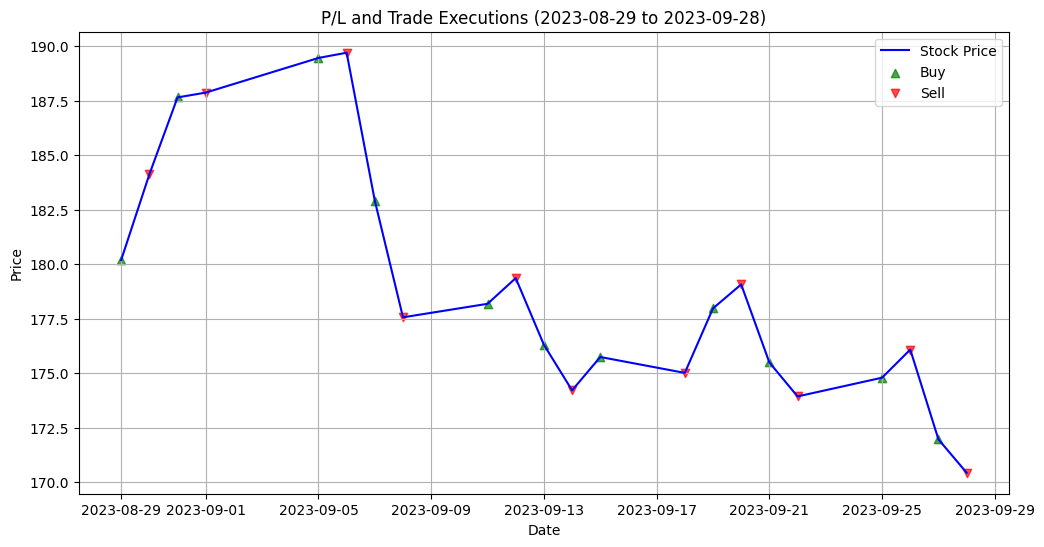

In [2]:
#Access the trade info from the Neural Network Strategy Class
%store trade_info
%store strategy

# Load the trade_info and strategy from the source notebook
%store -r trade_info
%store -r strategy

import matplotlib.pyplot as plt

# Function to plot profit/loss
def plot_profit_loss(trade_info, start_date, end_date):
    # Extract the dates, prices, and actions from trade_info
    prices = [info[0] for info in trade_info]  # Use info[0] for price
    shares = [info[1] for info in trade_info]  # Use info[1] for shares
    actions = [info[2] for info in trade_info]  # Use info[2] for action
    trade_dates = [info[3] for info in trade_info]  # Extract trade dates from the trade information

    # Filter trade executions
    buy_dates = [trade_dates[i] for i in range(len(trade_dates)) if actions[i] == "Buy"]
    sell_dates = [trade_dates[i] for i in range(len(trade_dates)) if actions[i] == "Sell"]

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, prices, label="Stock Price", color="blue")
    plt.scatter(buy_dates, [prices[trade_dates.index(date)] for date in buy_dates], label="Buy", marker="^", color="green", alpha=0.7)
    plt.scatter(sell_dates, [prices[trade_dates.index(date)] for date in sell_dates], label="Sell", marker="v", color="red", alpha=0.7)
    plt.title(f"P/L and Trade Executions ({start_date} to {end_date})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage in the target notebook:
start_date = '2023-08-29'
end_date = '2023-09-28'
plot_profit_loss(trade_info, start_date, end_date)


## Plot Liquidity

no stored variable or alias strategy


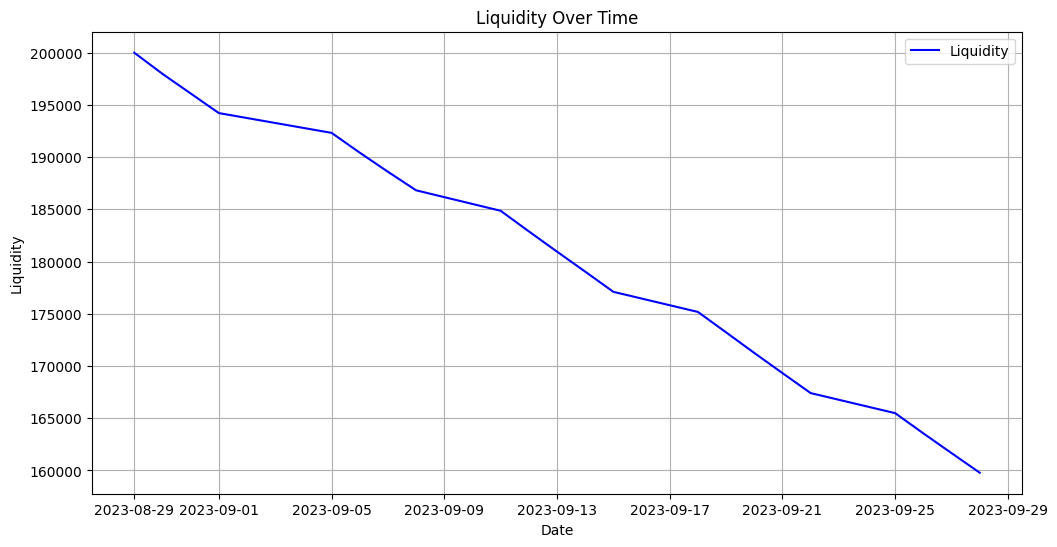

In [84]:
# Load trade_info from the Neural Network Strategy Class
%store -r trade_info

# Load your strategy class 
%store -r strategy

import matplotlib.pyplot as plt

def plot_liquidity(trade_info):
    """
    Plot liquidity over time based on trade information.

    Args:
        trade_info (list): List of trade information, including price, shares, action, and date.
    """
    dates = [trade[3] for trade in trade_info]  # Extract the trade dates from trade_info
    liquidity = [200000]  # Initialize liquidity with the initial balance of 200,000

    
    for i in range(1, len(trade_info)):
        #Initialize the trade info (action shares, and price) and initialize their variables
        action, shares, price = trade_info[i][2], trade_info[i][1], trade_info[i][0]

        
        if action == "Buy":
            liquidity.append(liquidity[-1] - (shares * price))
        elif action == "Sell":
            liquidity.append(liquidity[-1] + (shares * price))
        else:
            liquidity.append(liquidity[-1])  # For "No action" trades

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))
    plt.plot(dates, liquidity, label="Liquidity", color="blue")
    plt.title("Liquidity Over Time")
    plt.xlabel("Date")
    plt.ylabel("Liquidity")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage to plot liquidity
plot_liquidity(trade_info)
